In [1]:
# naive prediction model
# uses only elo in a hard coded logic model

import archives_manager

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.width', 10000)

In [3]:
# hard-coded logic naive model

def predict_win(archived_game, player_name):
    elo = archives_manager.get_elo(archived_game, player_name)

    if elo['Player'] > elo['Opponent']:
        return 1
    else:
        return 0

In [4]:
def get_player_analysis(player_name, num_games):
    recent_archive = archives_manager.get_most_recent_games(player_name, num_games, time_class='rapid', filter_func=archives_manager.build_archive_filter(rated=True, exclude_draws=True, max_elo_diff=150), correct_elo=True)

    lst = []

    for archived_game in recent_archive:
        pred = predict_win(archived_game, player_name)
        actual = archives_manager.get_won(archived_game, player_name)

        elo = archives_manager.get_elo(archived_game, player_name)

        lst.append({
            'unix': archived_game['end_time'],
            'player_elo': elo['Player'],
            'opp_elo': elo['Opponent'],
            'won': actual,
            'won_predict': pred,
            'correct': True if actual == pred else False,
            'elo_diff': elo['Player'] - elo['Opponent'],
        })

    df = pd.DataFrame(lst)

    return df, recent_archive

In [5]:
def analysis_prediction_stats(df):
    TP = len(df[(df['won_predict'] == 1) & (df['won'] == 1)])
    TN = len(df[(df['won_predict'] == 0) & (df['won'] == 0)])
    FP = len(df[(df['won_predict'] == 1) & (df['won'] == 0)])
    FN = len(df[(df['won_predict'] == 0) & (df['won'] == 1)])

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    return {
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN,
        'N': TP + TN + FP + FN,
        'accuracy': accuracy
    }

In [6]:
num_games_per_player = 1000

players = [
    'BIG_TONKA_T',
    'UnderTheBeer',
    'Dandres0_0',
    'Ale9800',
    'MrOGH'
]

def get_average_elo(archive, player_name):
    n = len(archive)
    avg = 0

    for archived_game in archive:
        avg += (archives_manager.get_elo(archived_game, player_name)['Player'] / n)

    return avg

analyses = []
stats_list = []

for player_name in players:
    df, recent_archive = get_player_analysis(player_name, num_games=num_games_per_player)
    
    player_info = {
        'Name': player_name,
        'Current Rating': archives_manager.get_elo(recent_archive[0], player_name)['Player'],
        'Average Rating': round(get_average_elo(recent_archive, player_name))
    }

    player_info.update(analysis_prediction_stats(df))

    analyses.append({
        'player_name': player_name,
        'stats': player_info,
        'data': df,
        'archive': recent_archive
    })

    stats_list.append(player_info)

stats_df = pd.DataFrame(stats_list)

overall_average_accuracy = np.mean(stats_df['accuracy'])
print('overall average accuracy', round(overall_average_accuracy, 3))

stats_df

overall average accuracy 0.517


,Name,Current Rating,Average Rating,TP,TN,FP,FN,N,accuracy
0,BIG_TONKA_T,1356,1384,293,257,232,218,1000,0.55000
1,UnderTheBeer,1271,1343,279,223,263,235,1000,0.50200
2,Dandres0_0,1441,1498,279,240,254,227,1000,0.51900
3,Ale9800,1400,1488,275,219,272,234,1000,0.49400
4,MrOGH,1271,1372,181,154,162,148,645,0.51938


In [7]:
for analysis in analyses:
    print(analysis['player_name'])
    print(analysis['data'])

BIG_TONKA_T
           unix  player_elo  opp_elo  won  won_predict  correct  elo_diff
0    1697181907        1356     1308    1            1     True        48
1    1697182382        1363     1328    1            1     True        35
2    1697184632        1370     1335    1            1     True        35
3    1697185674        1377     1338    0            1    False        39
4    1697185879        1368     1352    0            1    False        16
5    1697186263        1360     1326    1            1     True        34
6    1697186819        1367     1389    0            0     True       -22
7    1697187233        1359     1375    0            0     True       -16
8    1697188260        1351     1298    0            1    False        53
9    1697188653        1342     1329    0            1    False        13
10   1697188951        1334     1379    0            0     True       -45
11   1697189193        1327     1369    0            0     True       -42
12   1697189372        132

In [8]:
# split into correct and incorrect dataframes
data_list = [analysis['data'] for analysis in analyses]
df = pd.concat(data_list)

correct_df = df[df['correct'] == True]
incorrect_df = df[df['correct'] == False]

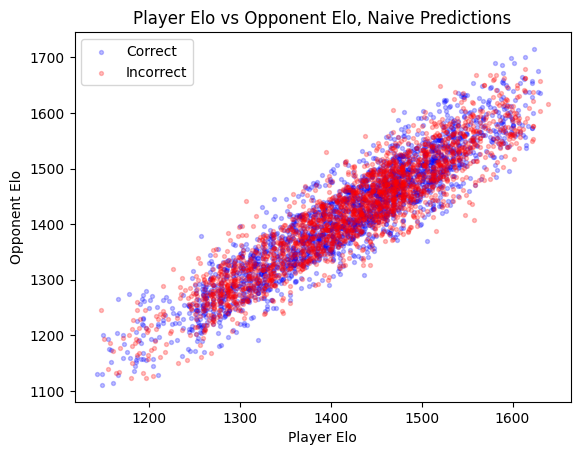

In [9]:
# player vs opponent elo predictions
plt.scatter(correct_df['player_elo'], correct_df['opp_elo'], color='blue', s=8, alpha=0.25, label='Correct')
plt.scatter(incorrect_df['player_elo'], incorrect_df['opp_elo'], color='red', s=8, alpha=0.25, label='Incorrect')

plt.xlabel('Player Elo')
plt.ylabel('Opponent Elo')
plt.title('Player Elo vs Opponent Elo, Naive Predictions')
plt.legend()
plt.show()

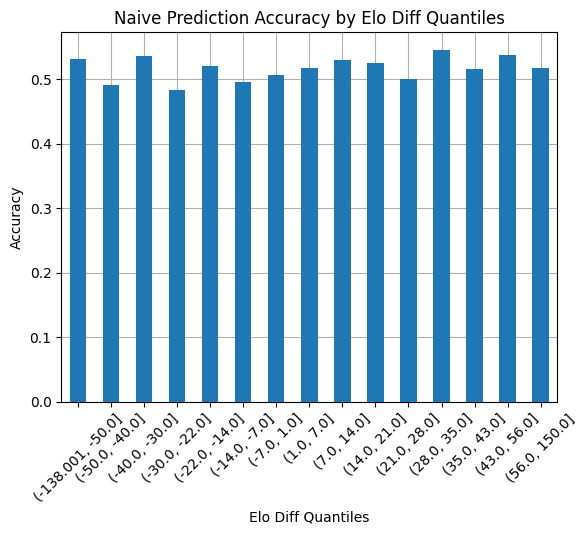

In [10]:
# accuracy by elo difference quantile
num_quantiles = 15
df['quantile'] = pd.qcut(df['elo_diff'], q=num_quantiles)
grouped = df.groupby('quantile', observed=False)['correct'].mean()
grouped.plot(kind='bar', zorder=3)

plt.xlabel('Elo Diff Quantiles')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.title('Naive Prediction Accuracy by Elo Diff Quantiles')
plt.grid(zorder=2)

# Show the plot
plt.show()